# CAPM in Python: Estimating Tesla's Beta (Local Data)

This notebook demonstrates a **simple, practical** CAPM beta estimation using **only local data files**.

## Goal
Estimate Tesla's beta by running a linear regression on **daily excess returns**:

$$
R_{i,t} - R_{f,t} = \alpha + \beta\,(R_{m,t} - R_{f,t}) + \varepsilon_t
$$

Shorthand (same idea):

$$
(R_i - R_f) = a + b\,(R_m - R_f)
$$

where $a$ corresponds to $\alpha$ and $b$ corresponds to $\beta$.

where:
- $R_{i,t}$: Tesla daily return
- $R_{m,t}$: S&P 500 daily return
- $R_{f,t}$: risk-free daily return (from 1-year US Treasury yield)


## Data requirements (local)

All inputs are read from `materials/data/` (or `data/` if you run the notebook from inside `materials/`).

- Tesla daily prices: `tesla_daily_price.xlsx`
- S&P 500 index level: `sp500_index_fred.csv`
- 1-year US Treasury yield: `us_1y_treasury_yield_dgs1.csv`

Return construction:
- Daily return: $(P_t / P_{t-1}) - 1$
- Risk-free yield is annualized; we convert it to a **daily** risk-free return using a 252-trading-day convention.


In [1]:
# Setup: imports + local paths
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

plt.style.use('seaborn-v0_8-whitegrid')

# Make paths robust whether Jupyter is launched from repo root or from `materials/`.
DATA_DIR = Path('data') if Path('data').exists() else Path('materials/data')

TSLA_PATH = DATA_DIR / 'tesla_daily_price.xlsx'
SP500_PATH = DATA_DIR / 'sp500_index_fred.csv'
RF_PATH = DATA_DIR / 'us_1y_treasury_yield_dgs1.csv'

for p in [TSLA_PATH, SP500_PATH, RF_PATH]:
    if not p.exists():
        raise FileNotFoundError(
            f"Missing local file: {p.resolve()}\n"
            "Place the required datasets under materials/data/ before running."
        )

TSLA_PATH, SP500_PATH, RF_PATH


(WindowsPath('data/tesla_daily_price.xlsx'),
 WindowsPath('data/sp500_index_fred.csv'),
 WindowsPath('data/us_1y_treasury_yield_dgs1.csv'))

In [2]:
# Load datasets
tsla = pd.read_excel(TSLA_PATH, index_col=0)
tsla.index = pd.to_datetime(tsla.index)
tsla = tsla.sort_index()

sp500 = pd.read_csv(SP500_PATH)
sp500['Date'] = pd.to_datetime(sp500['Date'])
sp500 = sp500.set_index('Date').sort_index()

rf = pd.read_csv(RF_PATH)
rf['Date'] = pd.to_datetime(rf['Date'])
rf = rf.set_index('Date').sort_index()

print('TSLA range:', tsla.index.min().date(), 'to', tsla.index.max().date(), 'rows', len(tsla))
print('SP500 range:', sp500.index.min().date(), 'to', sp500.index.max().date(), 'rows', len(sp500))
print('DGS1 range:', rf.index.min().date(), 'to', rf.index.max().date(), 'rows', len(rf))

tsla[['Close']].head()


TSLA range: 2024-01-02 to 2025-12-30 rows 501
SP500 range: 2024-01-02 to 2025-12-30 rows 521
DGS1 range: 2024-01-02 to 2025-12-30 rows 521


,Close
Date,
2024-01-02,248.419998
2024-01-03,238.449997
2024-01-04,237.929993
2024-01-05,237.490005
2024-01-08,240.449997


## Step 1 — Build daily returns

We compute daily simple returns:

$$
R_t = \frac{P_t}{P_{t-1}} - 1
$$

For the risk-free rate, the 1-year Treasury series is an **annualized yield** (percent per year).
We convert it to a daily return using:

$$
R_{f,\,daily} = (1+R_{f,\,annual})^{1/252} - 1
$$


In [3]:
# Daily returns: Tesla and S&P 500
Ri = tsla['Close'].pct_change().rename('Ri')
Rm = sp500['SP500'].pct_change().rename('Rm')

# Align Tesla and market returns first (trading days)
ret = pd.concat([Ri, Rm], axis=1).dropna()

# Risk-free: DGS1 is an annual yield in percent (e.g., 5.2 means 5.2% per year)
rf_annual = (rf['DGS1'] / 100.0).rename('Rf_annual').ffill()
rf_annual = rf_annual.reindex(ret.index).ffill()

# Convert annual yield to daily return (252 trading days convention)
Rf_daily = ((1 + rf_annual) ** (1 / 252) - 1).rename('Rf_daily')

df = ret.join(Rf_daily).dropna()
df['Excess_i'] = df['Ri'] - df['Rf_daily']
df['Excess_m'] = df['Rm'] - df['Rf_daily']

df.head()


C:\Users\Jinquan Ye\AppData\Local\Temp\ipykernel_27844\4175911356.py:3: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  Rm = sp500['SP500'].pct_change().rename('Rm')


,Ri,Rm,Rf_daily,Excess_i,Excess_m
Date,,,,,
2024-01-03,-0.040134,-0.008016,0.000186,-0.040320,-0.008203
2024-01-04,-0.002181,-0.003428,0.000188,-0.002369,-0.003616
2024-01-05,-0.001849,0.001826,0.000188,-0.002037,0.001638
2024-01-08,0.012464,0.014115,0.000187,0.012277,0.013928
2024-01-09,-0.022832,-0.001478,0.000187,-0.023019,-0.001665


In [4]:
# (Optional) Annualize average returns for interpretation (not needed for beta estimation)
def annualize_return_geom(daily_returns: pd.Series, periods_per_year: int = 252) -> float:
    r = daily_returns.dropna().to_numpy()
    if r.size == 0:
        return float('nan')
    return float((np.prod(1 + r) ** (periods_per_year / r.size)) - 1)

def annualize_vol(daily_returns: pd.Series, periods_per_year: int = 252) -> float:
    return float(daily_returns.dropna().std() * np.sqrt(periods_per_year))

summary = pd.DataFrame(
    {
        'Ann. return (geom)': [
            annualize_return_geom(df['Ri']),
            annualize_return_geom(df['Rm']),
            annualize_return_geom(df['Rf_daily']),
        ],
        'Ann. vol': [
            annualize_vol(df['Ri']),
            annualize_vol(df['Rm']),
            annualize_vol(df['Rf_daily']),
        ],
    },
    index=['TSLA', 'S&P 500', 'Risk-free (proxy)'],
)
summary


,Ann. return (geom),Ann. vol
TSLA,0.355780,0.635607
S&P 500,0.207641,0.159827
Risk-free (proxy),0.042979,0.000306


## Step 2 — CAPM regression (beta estimation)

We estimate beta using OLS:

$$
R_{i,t} - R_{f,t} = \alpha + \beta\,(R_{m,t} - R_{f,t}) + \varepsilon_t
$$

Shorthand:

$$
(R_i - R_f) = a + b\,(R_m - R_f)
$$

- The slope $b$ (i.e., $\beta$) is the **beta estimate**.
- The intercept $a$ (i.e., $\alpha$) is often interpreted as **abnormal return** (should be ~0 in a strict CAPM world).


In [5]:
# Run OLS regression
X = sm.add_constant(df['Excess_m'])
y = df['Excess_i']

model = sm.OLS(y, X).fit()
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Excess_i   R-squared:                       0.351
Model:                            OLS   Adj. R-squared:                  0.350
Method:                 Least Squares   F-statistic:                     269.8
Date:                Wed, 11 Feb 2026   Prob (F-statistic):           9.19e-49
Time:                        10:47:42   Log-Likelihood:                 1008.2
No. Observations:                 500   AIC:                            -2012.
Df Residuals:                     498   BIC:                            -2004.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.235      0.814      -0.003       0.003
Excess_m       2.3575      0.144     16.425      0.000       2.075       2.639
==============================================================================
Omnibus:                      100.232   Durbin-Watson:                   1.852
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              651.646
Skew:                           0.685   Prob(JB):                    3.14e-142
Kurtosis:                       8.422   Cond. No.                         99.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
# Extract alpha and beta
alpha = float(model.params['const'])
beta = float(model.params['Excess_m'])
r2 = float(model.rsquared)

{'alpha (daily)': alpha, 'beta': beta, 'R^2': r2}


{'alpha (daily)': 0.0003397579843015911,
 'beta': 2.3574774423725495,
 'R^2': 0.3513853711624617}

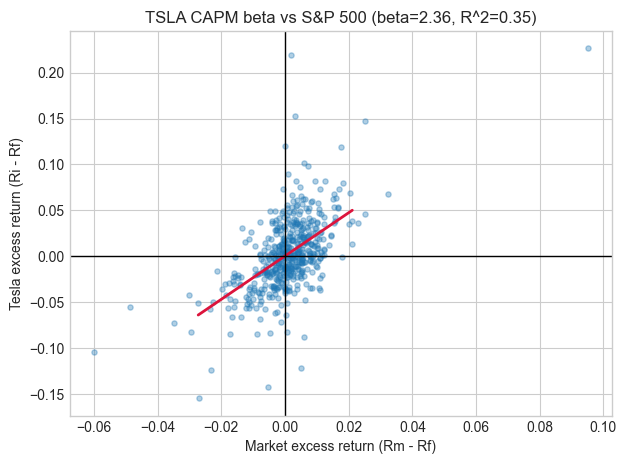

In [7]:
# Visualize: scatter + fitted line
x = df['Excess_m']
y = df['Excess_i']

plt.figure(figsize=(7, 5))
plt.scatter(x, y, alpha=0.35, s=14)

x_line = np.linspace(x.quantile(0.01), x.quantile(0.99), 200)
y_line = alpha + beta * x_line
plt.plot(x_line, y_line, color='crimson', linewidth=2)

plt.title(f"TSLA CAPM beta vs S&P 500 (beta={beta:.2f}, R^2={r2:.2f})")
plt.xlabel('Market excess return (Rm - Rf)')
plt.ylabel('Tesla excess return (Ri - Rf)')
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.show()


## Quick interpretation

- If $\beta > 1$, Tesla tends to move **more** than the market (higher systematic risk).
- If $\beta < 1$, Tesla tends to move **less** than the market.
- Beta is **dimensionless**; it summarizes sensitivity of the stock to market movements.

In valuation, beta is commonly used to compute the **cost of equity** via CAPM:

$$
R_e = R_f + \beta\,(E[R_m] - R_f)
$$
